## # Validation script for Mauritania

In [1]:
import os, sys, glob, json
from itertools import product, compress, chain
from functools import reduce
import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)
import requests
import numpy as np
import pandas as pd
import geopandas as gpd
import matplotlib
import matplotlib.pyplot as plt
from matplotlib.dates import DateFormatter
import seaborn as sns
from tools import save_hdf, save_npz, load_npz, PrintAdminUnits, PlotAdminShapes
from tools import FDW_PD_Sweeper, FDW_PD_AvalTable, FDW_PD_Compiling, FDW_PD_GrainTypeAgg, FDW_PD_ValidateFnidName
from tools import FDW_PD_CreateAdminLink, FDW_PD_RatioAdminLink, FDW_PD_ConnectAdminLink
from tools import FDW_PD_CaliSeasonYear
from tools_graphic import PlotBarProduction, PlotLinePAY, PlotHeatCropSystem, PlotHeatSeasonData
import plotly.express as px
import plotly.graph_objects as go
from plotly.subplots import make_subplots
warnings.simplefilter(action='ignore', category=pd.errors.PerformanceWarning)
pd.options.mode.chained_assignment = None

## Yield Data

In [2]:
# Load GSCD crop data -------------------------------- #
country_iso, country_name = 'MR', 'Mauritania'
df = pd.read_hdf('../data/crop/adm_crop_production_%s.hdf' % country_iso)
df = df[df['gscd_code']=='calibrated']; fnids = list(df['fnid'].unique())
df = df[
    (df['season_name'] == 'Main') &
    (df['product'].isin(['Maize']))
]
area = df[df['indicator'] == 'area']
area['year'] = area['harvest_year']
area = area.pivot_table(index='year',columns='product',values='value',aggfunc='sum').sum(1).rename('FDW')

prod = df[df['indicator'] == 'production']
prod['year'] = prod['harvest_year']
prod = prod.pivot_table(index='year',columns='product',values='value',aggfunc='sum').sum(1).rename('FDW')
data = prod/area
# ---------------------------------------------------- #
data

year
1999    0.385573
2000    1.210847
2001    1.367089
2002    0.578947
2003    0.914857
2004    0.350783
2005    0.718333
2006    0.645033
2007    0.715649
2008    0.200000
2009    0.331731
2010         NaN
2011         NaN
2012    0.499950
2013    0.346939
2014         NaN
2015    0.397059
2016    0.237209
Name: FDW, dtype: float64

## Main maize season comparison to FAO

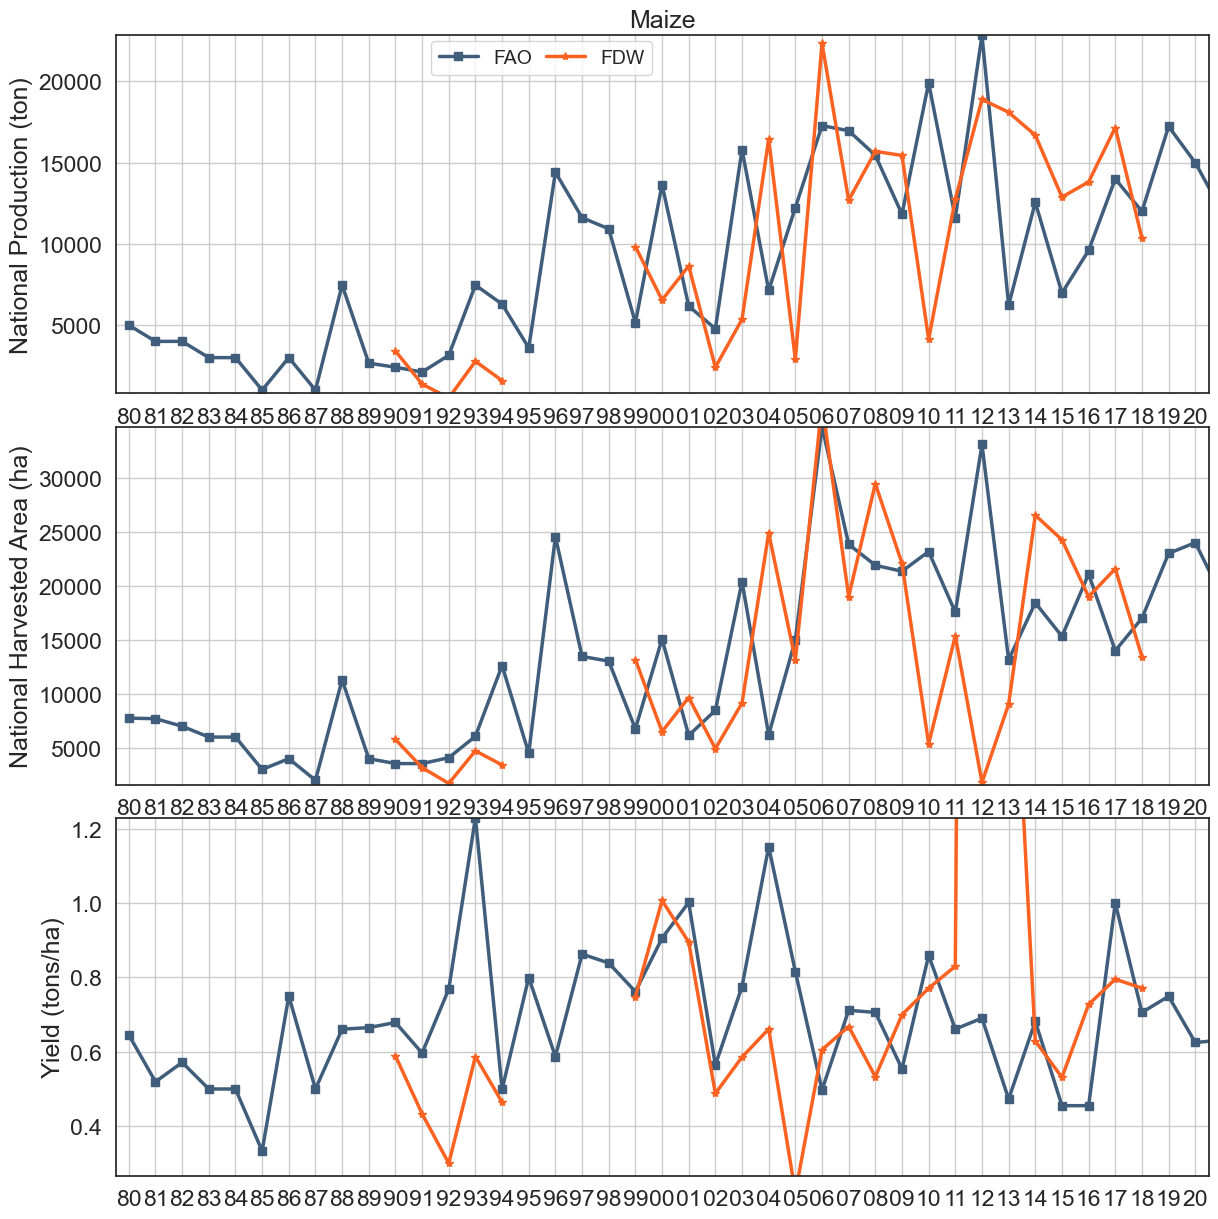

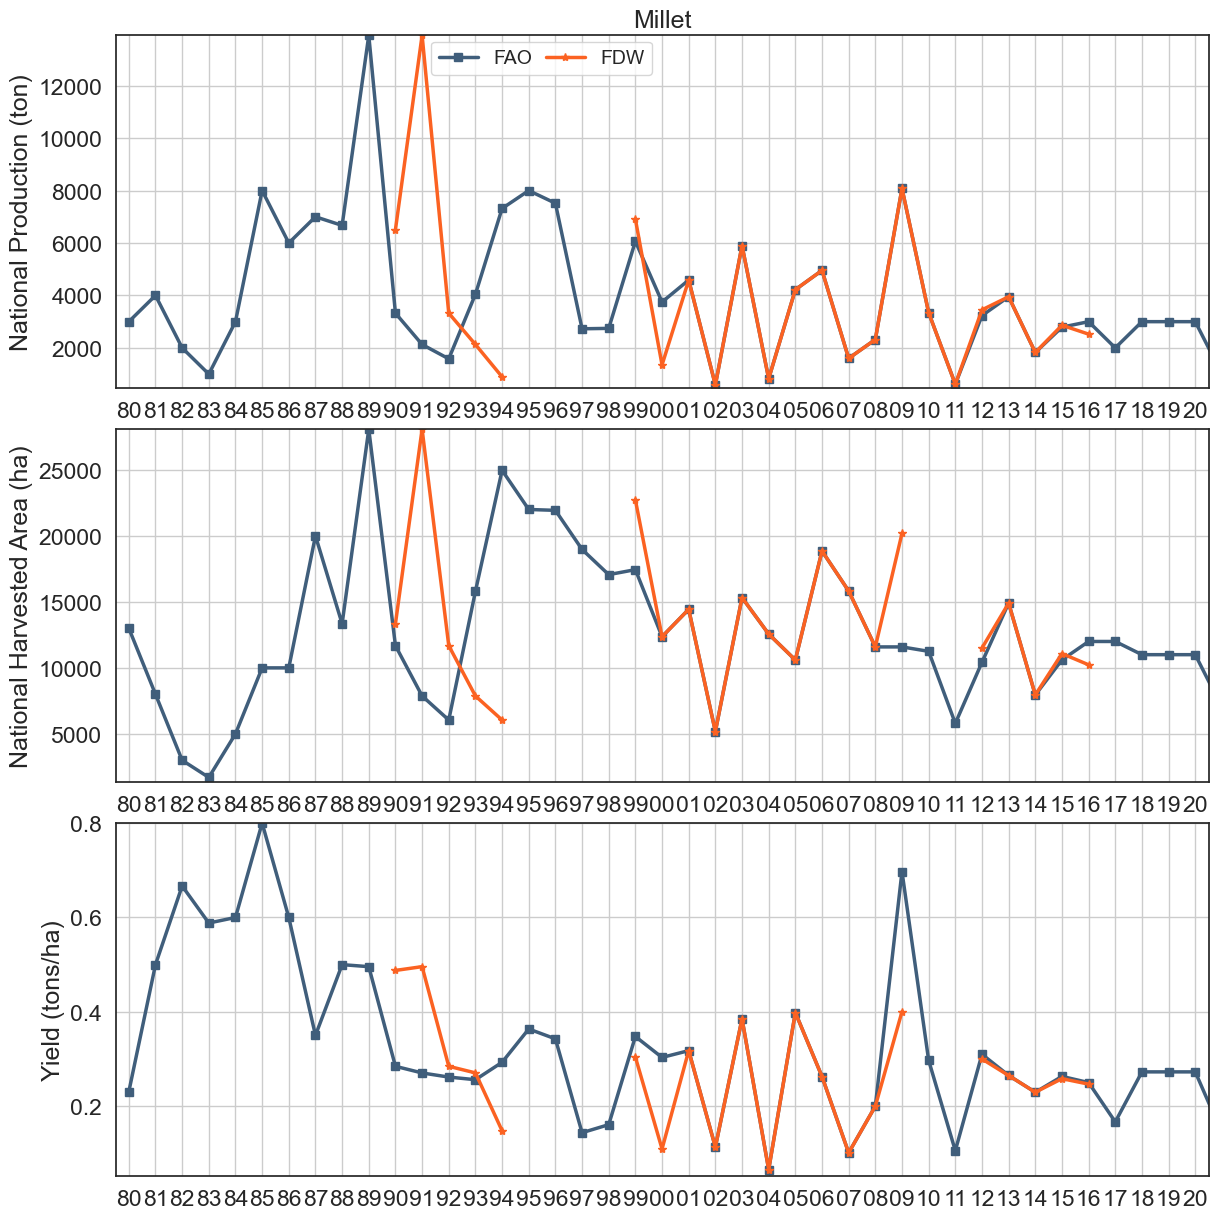

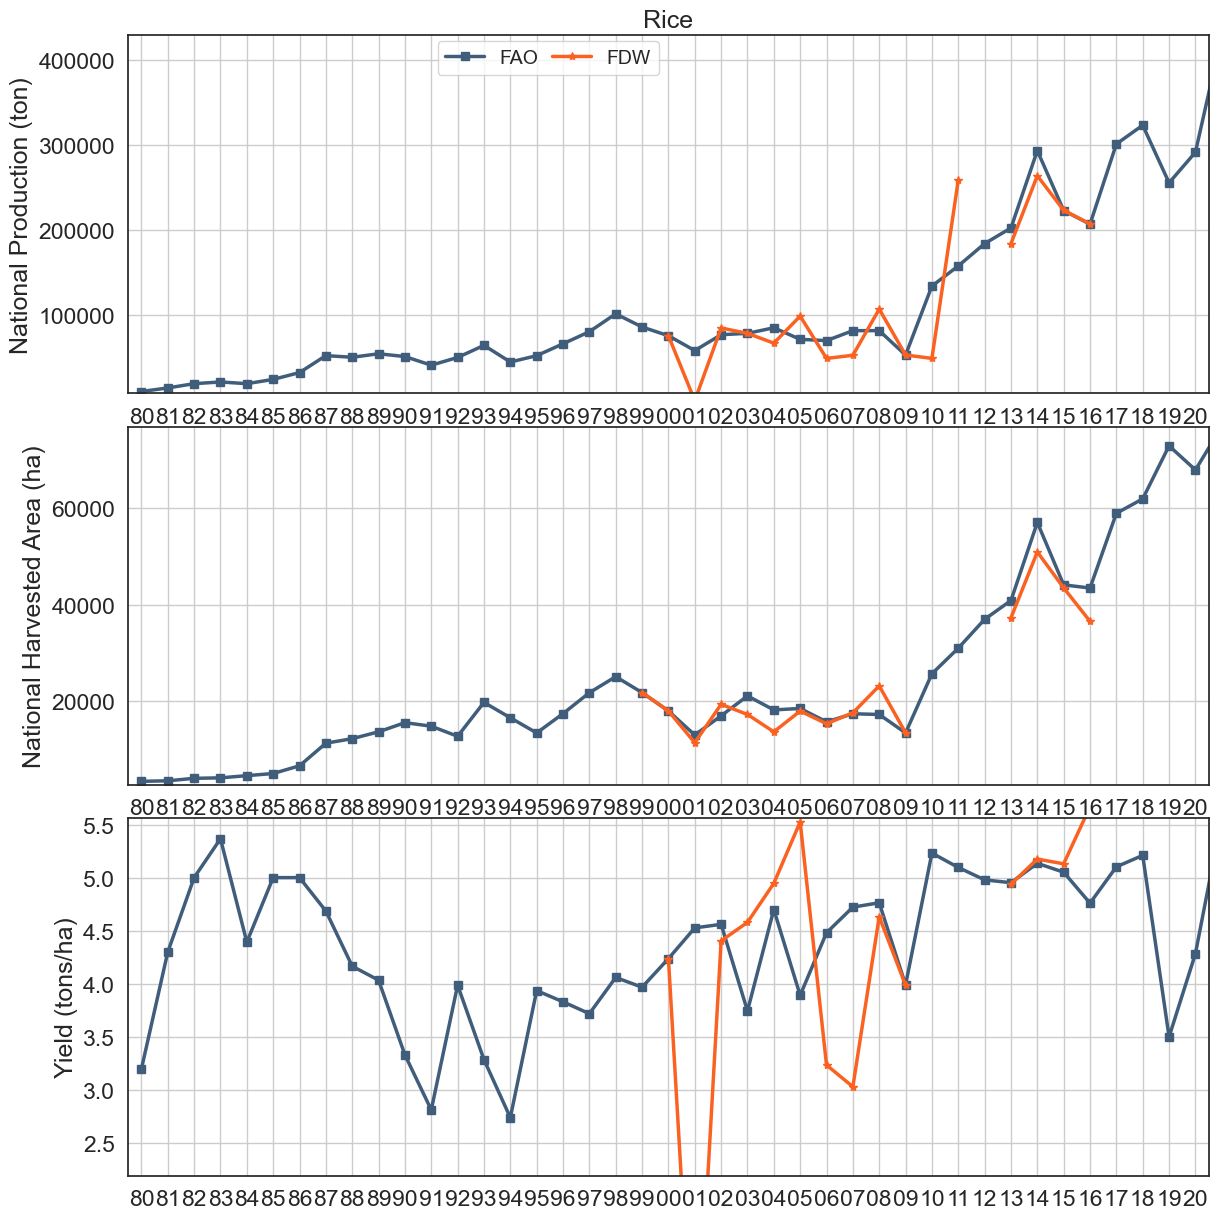

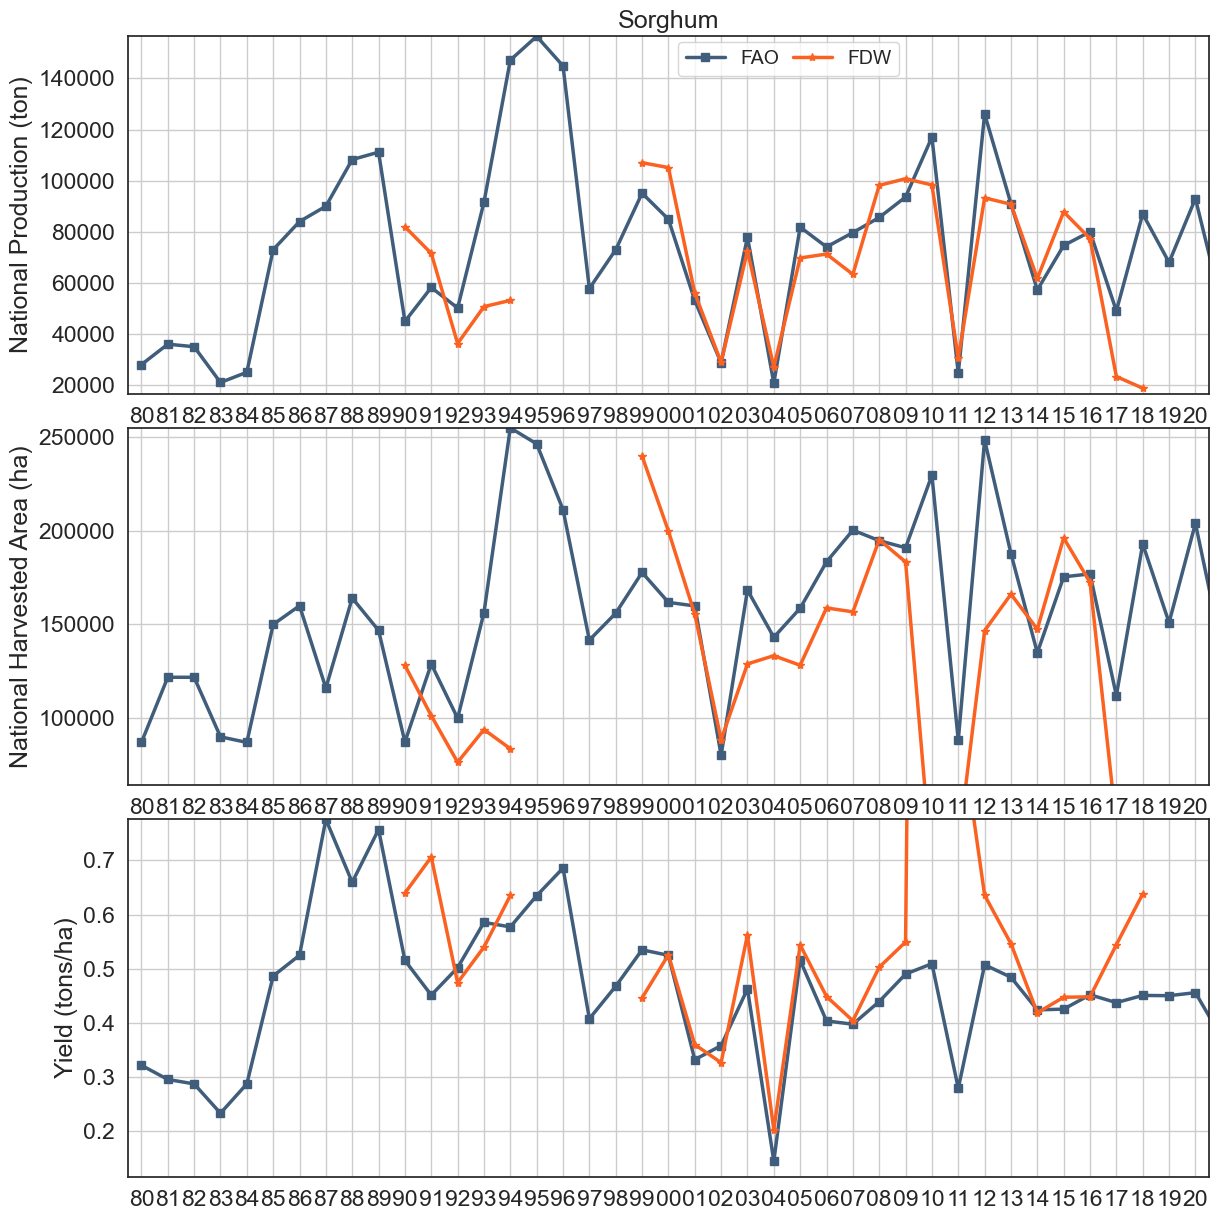

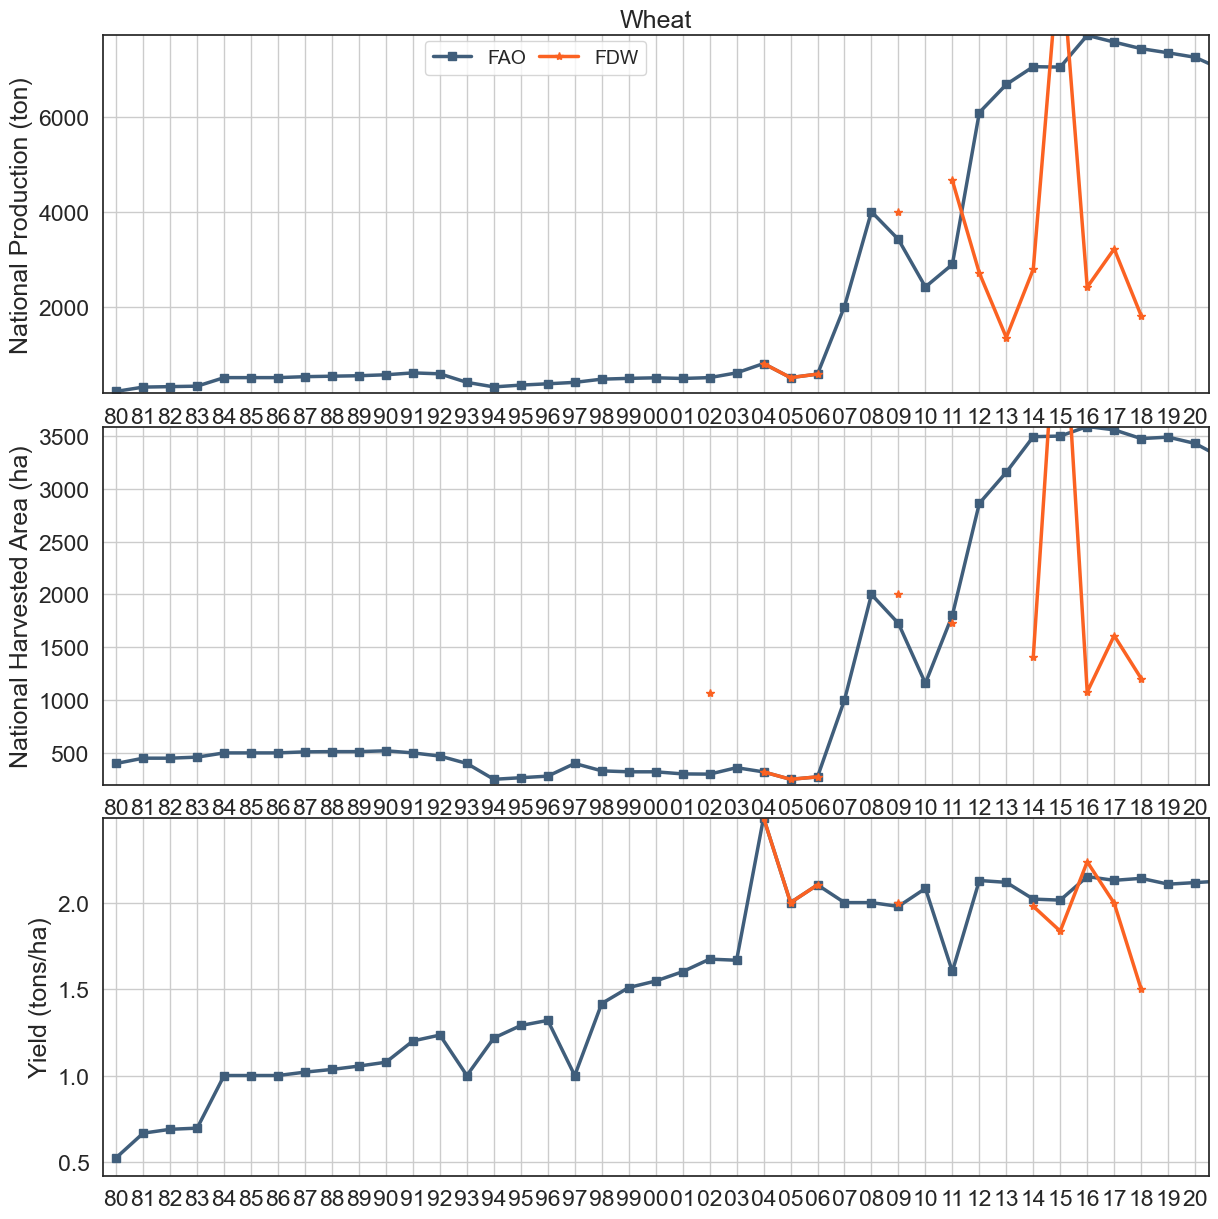

In [3]:
# Load GSCD crop data -------------------------------- #
country_iso, country_name = 'MR', 'Mauritania'
df1 = pd.read_hdf('../data/crop/adm_crop_production_%s.hdf' % country_iso)
df1 = df1[df1['gscd_code']=='calibrated']; fnids = list(df1['fnid'].unique())


# Load FAO-STAT National Production Data ------------- #
df2 = pd.read_csv('../data/crop/fao.csv', index_col=0)

product_season = [
   
    ['Maize','Main','Maize (corn)'],
#     ['Maize','Main'],
#     ['Maize','Annual'],
#     ['Maize','Bas-fond'],
#     ['Maize','Dam retention'],
#     ['Maize', 'Walo'],
    ['Millet','Annual','Millet'],
#     ['Millet','Main'],
#     ['Rice','Walo'],
    ['Rice','Main','Rice'],
#     ['Rice','Bas-fond'],
#     ['Rice','Dam retention'],
#     ['Rice','Hot off-season'],
#     ['Sorghum','Walo'],
#     ['Sorghum','Main'],
#     ['Sorghum','Bas-fond'],
#     ['Sorghum','Dam retention'],
    ['Sorghum','Annual','Sorghum'],
    ['Wheat','Bas-fond','Wheat'],
#     ['Wheat','Cold off-season'],
#     ['Wheat','Dam retention']
]
   
for ps in product_season:
    df = df1[
#         (df1['season_name'] == ps[1]) &
        (df1['product'].isin([ps[0]])) &
        (df1['indicator'] == 'production')
        ]
    df['year'] = df['harvest_year']
    data_fdw_pr = df.pivot_table(index='year', columns='product', values='value', aggfunc='sum').sum(1).rename('FDW')
    # ---------------------------------------------------- #

    data_fao = df2[
        (df2['Area'] == 'Mauritania') &
        (df2['Item'] == ps[2]) &
        (df2['Element'] == 'Production')
        ].set_index('Year')['Value']
    # ---------------------------------------------------- #
    data = pd.concat([data_fao, data_fdw_pr], axis=1, keys=['FAO', 'FDW']).sort_index()

    # Validation figure ---------------------------------- #
    years = np.arange(1980, 2021)
    sns.set(style="white", font_scale=1.5)
    fig = plt.figure(figsize=(12, 12))
    ax1 = plt.subplot(311)
    plt.title(ps[0])
    data.plot(ax=ax1, legend=None, linewidth=2.5, marker='s', color=['#405E7B', '#FB6222', '#17AB6F'])
    marker = ['s', '*']
    for i, line in enumerate(ax1.get_lines()): line.set_marker(marker[i])
    ax1.set_xlim([years.min() - 0.5, years.max() + 0.5])
    ax1.set_ylim([np.min(data_fao) - (.2 * np.min(data_fao)), np.max(data_fao)])
    ax1.set_xticks(years)
    ax1.set_xticklabels(['%02d' % yr for yr in np.mod(years, 100)])
    ax1.xaxis.grid(True)
    ax1.grid(True)
    ax1.set_xlabel('')
    ax1.set_ylabel('National Production (ton)')

    ax1.legend(bbox_to_anchor=(0.5, 1.01), columnspacing=0.7, ncol=3, fontsize=14)

    # ---------------------------------------------------- #

    df = df1[
#         (df1['season_name'] == ps[1]) &
        (df1['product'].isin([ps[0]])) &
        (df1['indicator'] == 'area')
        ]
    df['year'] = df['harvest_year']
    data_fdw_a = df.pivot_table(index='year', columns='product', values='value', aggfunc='sum').sum(1).rename('FDW')
    # ---------------------------------------------------- #

    data_fao = df2[
        (df2['Area'] == 'Mauritania') &
        (df2['Item'] == ps[2]) &
        (df2['Element'] == 'Area harvested')
        ].set_index('Year')['Value']
    # ---------------------------------------------------- #
    data = pd.concat([data_fao, data_fdw_a], axis=1, keys=['FAO', 'FDW']).sort_index()

    # Validation figure ---------------------------------- #
    ax2 = plt.subplot(312)
    data.plot(ax=ax2, legend=None, linewidth=2.5, marker='s', color=['#405E7B', '#FB6222', '#17AB6F'])
    marker = ['s', '*']
    for i, line in enumerate(ax2.get_lines()): line.set_marker(marker[i])
    ax2.set_xlim([years.min() - 0.5, years.max() + 0.5])
    ax2.set_ylim([np.min(data_fao) - (.2 * np.min(data_fao)), np.max(data_fao)])
    ax2.set_xticks(years)
    ax2.set_xticklabels(['%02d' % yr for yr in np.mod(years, 100)])
    ax2.xaxis.grid(True)
    ax2.grid(True)
    ax2.set_xlabel('')
    ax2.set_ylabel('National Harvested Area (ha)')

    # ---------------------------------------------------- #

    data_fdw = data_fdw_pr / data_fdw_a
    # ---------------------------------------------------- #

    data_fao = df2[
                   (df2['Area'] == 'Mauritania') &
                   (df2['Item'] == ps[2]) &
                   (df2['Element'] == 'Yield')
                   ].set_index('Year')['Value'] / 10000  # convert hg/ha to tons/ha
    # ---------------------------------------------------- #
    data = pd.concat([data_fao, data_fdw], axis=1, keys=['FAO', 'FDW']).sort_index()

    # Validation figure ---------------------------------- #
    ax3 = plt.subplot(313)
    data.plot(ax=ax3, legend=None, linewidth=2.5, marker='s', color=['#405E7B', '#FB6222', '#17AB6F'])
    marker = ['s', '*']
    for i, line in enumerate(ax3.get_lines()): line.set_marker(marker[i])
    ax3.set_xlim([years.min() - 0.5, years.max() + 0.5])
    ax3.set_ylim([np.min(data_fao) - (.2 * np.min(data_fao)), np.max(data_fao)])
    ax3.set_xticks(years)
    ax3.set_xticklabels(['%02d' % yr for yr in np.mod(years, 100)])
    ax3.xaxis.grid(True)
    ax3.grid(True)
    ax3.set_xlabel('')
    ax3.set_ylabel('Yield (tons/ha)')

    plt.tight_layout(pad=0)
    plt.show()


